In [5]:
##############      Configuración      ##############
import os
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict
from PIL import Image
from dotenv import dotenv_values

pd.set_option('display.max_columns', None)
env = dotenv_values("globals.env")

path_proyecto   = env['PATH_PROYECTO']    
path_datain     = env['PATH_DATAIN']
path_dataout    = env['PATH_DATAOUT']
path_scripts    = env['PATH_SCRIPTS']    
path_satelites  = env['PATH_SATELITES']
path_logs       = env['PATH_LOGS']     
path_outputs    = env['PATH_OUTPUTS']     
# path_programas  = globales[7]

In [6]:
import affine
import geopandas as gpd
import rasterio.features
import xarray as xr
import shapely.geometry as sg
import pandas as pd 

def polygonize(da: xr.DataArray) -> gpd.GeoDataFrame:
    """
    Polygonize a 2D-DataArray into a GeoDataFrame of polygons.

    Parameters
    ----------
    da : xr.DataArray

    Returns
    -------
    polygonized : geopandas.GeoDataFrame
    """
    if da.dims != ("y", "x"):
        raise ValueError('Dimensions must be ("y", "x")')

    values = da.values
    transform = da.attrs.get("transform", None)
    if transform is None:
        raise ValueError("transform is required in da.attrs")
    transform = affine.Affine(*transform)
    shapes = rasterio.features.shapes(values, transform=transform)

    geometries = []
    colvalues = []
    for (geom, colval) in shapes:
        geometries.append(sg.Polygon(geom["coordinates"][0]))
        colvalues.append(colval)

    gdf = gpd.GeoDataFrame({"value": colvalues, "geometry": geometries})
    gdf.crs = da.attrs.get("crs")
    return gdf


In [7]:
def get_dataset_extent(ds):
    ''' Return a polygon with the extent of the dataset 
    
    Params:
    ds: xarray dataset
    
    Returns:
    polygon: shapely polygon with the extent of the dataset          
    '''
    
    x_min = ds.x.min()
    x_max = ds.x.max()
    y_min = ds.y.min()
    y_max = ds.y.max()
    
    bbox = (x_min, y_min, x_max, y_max)
    
    # Turn bbox into a shapely polygon
    polygon = sg.box(*bbox)
    
    return polygon

In [8]:
files = os.listdir(fr"{path_datain}\Pansharpened\2013")
files = [f for f in files if f.endswith('.tif')]
datasets = {f.replace('.tif', "") : xr.open_dataset(fr"{path_datain}\Pansharpened\2013\{f}") for f in files}
extents = {name: get_dataset_extent(ds) for name, ds in datasets.items()}

In [9]:
def random_point_from_geometry(gdf_slice, size=100):
    """Generates a random point within the bounds of a GeoDataFrame."""

    # Get bounds of the shapefile's polygon
    bbox = gdf_slice.bounds

    while 0 == 0:
        # generate random data within the bounds
        x = np.random.uniform(bbox["minx"], bbox["maxx"], 1)
        y = np.random.uniform(bbox["miny"], bbox["maxy"], 1)

        # convert them to a points GeoSeries
        gdf_points = gpd.GeoSeries(gpd.points_from_xy(x, y), crs=3857)
        # only keep those points within polygons
        gdf_points = gdf_points[gdf_points.within(gdf_slice.unary_union)]
        if len(gdf_points) > 0:
            # If one point is found, stop the loop
            return (x,y)

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_nearest_raster(x_array, y_array, x_value, y_value):
    x_idx = find_nearest_idx(x_array, x_value)
    y_idx = find_nearest_idx(y_array, y_value)
    return x_idx, y_idx

In [10]:
# urbanData = xr.open_dataset(f'{path_datain}\WSF 2015 - Urbanizacion\WSF 2015 AMBA.tif')

In [11]:
icpag = gpd.read_file(fr"{path_datain}\ICPAG\base_icpag_500k.shp")
icpag = icpag.to_crs(epsg=4326)
icpag = icpag[icpag.AMBA_legal == 1].reset_index(drop=True)

collapse_link = pd.read_stata(fr"{path_datain}\predict_ingreso_collapse.dta")

In [12]:
# Merge icpag indicators with ELL estimation
icpag['link'] = icpag['link'].astype(str).str.zfill(9)
collapse_link['link'] = collapse_link['link'].astype(str).str.zfill(9)

icpag = icpag.merge(collapse_link, on='link', how='left', validate='1:1')

C:\Users\ofici\AppData\Local\Temp\ipykernel_232\349232987.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  icpag.loc[icpag.centroid.within(bbox), 'dataset'] = name
C:\Users\ofici\AppData\Local\Temp\ipykernel_232\349232987.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  icpag.loc[icpag.centroid.within(bbox), 'dataset'] = name


Links without images: 3448 out of 15114


<Axes: >

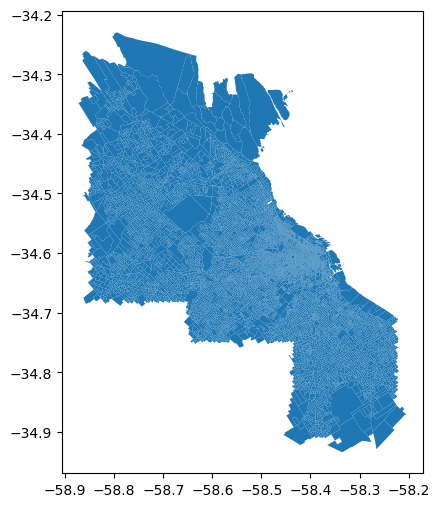

In [170]:
# Assign each link a dataset if the census tract falls within the extent of the dataset (images)
for name, bbox in extents.items():
    icpag.loc[icpag.centroid.within(bbox), 'dataset'] = name
    
print("Links without images:", icpag.dataset.isna().sum(), "out of", len(icpag))

icpag[icpag.dataset.notna()].plot(figsize=(6,6))

In [227]:
def random_image_from_census_tract(ds, icpag, link, tiles=1, size=100, to8bit=True):
    ''' Genera una imagen aleatoria de tamaño size centrada en un punto aleatorio del radio censal {link}.
    
    Parameters:
    -----------
    ds: xarray.Dataset, dataset con las imágenes de satélite
    icpag: geopandas.GeoDataFrame, shapefile con los radios censales
    link: str, 9 dígitos que identifican el radio censal
    size: int, tamaño de la imagen a generar, en píxeles
    tiles: int, cantidad de imágenes a generar por lado
    to8bit: bool, si es True, convierte la imagen a 8 bits
    
    Returns:
    --------
    image: numpy.ndarray, imagen de tamaño size x size            
    point: tuple, coordenadas del punto seleccionado
    
    '''

    images = []
    tile_size = size // tiles
    for tile in range(0, tiles**2):
        if tile==0:
            max_bias = 0
        else:
            max_bias = tile_size * 4
            
        # Obtengo un punto aleatorio del radio censal con un buffer de tamaño size
        x, y = random_point_from_geometry(icpag.loc[icpag["link"] == link], tile_size)
        point = (x[0], y[0])

        # Identifico el raster más cercano a este punto -- va a ser el centro de la imagen
        idx_x, idx_y = find_nearest_raster(ds.x, ds.y, x, y, max_bias=max_bias)

        # # Genero el cuadrado que quiero capturar en la imagen
        idx_x_min = round(idx_x - tile_size / 2)
        idx_x_max = round(idx_x + tile_size / 2)
        idx_y_min = round(idx_y - tile_size / 2)
        idx_y_max = round(idx_y + tile_size / 2)

        # Filtro el dataset para quedarme con esa imagen
        my_ds = ds.isel(x=slice(idx_x_min, idx_x_max), y=slice(idx_y_min, idx_y_max))

        image = my_ds.band_data.to_numpy().astype(np.uint16)
        images += [image]

    stacks = []
    for i in range(0, tiles):
        stack = np.hstack(images[i::tiles])
        stacks += [stack]
        
    composition = np.dstack(stacks)
    
    if to8bit:
        composition = np.array(composition >> 6, dtype=np.uint8)

    return composition, point


In [204]:
def random_image_from_census_tract_old(ds, icpag, link, size=100, to8bit=True):
    """Genera una imagen aleatoria de tamaño size centrada en un punto aleatorio del radio censal {link}.

    Parameters:
    -----------
    ds: xarray.Dataset, dataset con las imágenes de satélite
    icpag: geopandas.GeoDataFrame, shapefile con los radios censales
    link: str, 9 dígitos que identifican el radio censal
    size: int, tamaño de la imagen a generar, en píxeles

    Returns:
    --------
    image: numpy.ndarray, imagen de tamaño size x size
    point: tuple, coordenadas del punto seleccionado

    """

    # Obtengo un punto aleatorio del radio censal con un buffer de tamaño size
    x, y = random_point_from_geometry(icpag.loc[icpag["link"] == link], size)
    point = (x[0], y[0])

    # Identifico el raster más cercano a este punto -- va a ser el centro de la imagen
    idx_x, idx_y = find_nearest_raster(ds.x, ds.y, x, y)

    # # Genero el cuadrado que quiero capturar en la imagen
    idx_x_min = round(idx_x - size // 2)
    idx_x_max = round(idx_x + size // 2)
    idx_y_min = round(idx_y - size // 2)
    idx_y_max = round(idx_y + size // 2)

    # Filtro el dataset para quedarme con esa imagen
    my_ds = ds.isel(x=slice(idx_x_min, idx_x_max), y=slice(idx_y_min, idx_y_max))

    image = my_ds.band_data.to_numpy().astype(np.uint16)

    if to8bit:
        # https://stackoverflow.com/questions/2816144/python-convert-12-bit-image-encoded-in-a-string-to-8-bit-png
        image = np.array(image >> 6, dtype=np.uint8)

    return image, point


In [228]:
import earthpy.plot as ep
from tqdm import tqdm

icpag = icpag[icpag.dataset.notna()]

# Params
sample_size = 10
size = 512 # In pixels (or raster cells). size along one side of the square
metadata = {}
chunk_size = 1000
tiles = 2

# Algorithm
os.makedirs(fr"{path_dataout}\size{size}_sample{sample_size}", exist_ok=True)
counter = 0
chunk = 0
my_arrays = {}
img = np.zeros((4, 2, 2))
real_size = size // tiles * tiles
for link in tqdm(icpag.link.unique()):
    
    current_ds_name = icpag.loc[icpag.link == link,'dataset'].values[0]
    current_ds = datasets[current_ds_name]
    
    for n in range(sample_size):

        name = f"{link}_{n}"
        
        while img.shape != (4, real_size, real_size):
            # The image could be in the border of the dataset, so we need to try again until we get a valid image
            img, point = random_image_from_census_tract(current_ds, icpag, link, tiles=tiles, size=size, to8bit=True)
            print(img.shape)

        my_arrays[name] = img
        metadata["name"] = {"point":point, "sample":n, "link":link}
    
    # np.save(fr"{path_dataout}\size{size}_sample{sample_size}\link{link}", my_arrays) 
    print()       
    my_arrays = {}
    break

  0%|          | 0/11666 [00:00<?, ?it/s]

  0%|          | 0/11666 [00:00<?, ?it/s]

(4, 512, 512)



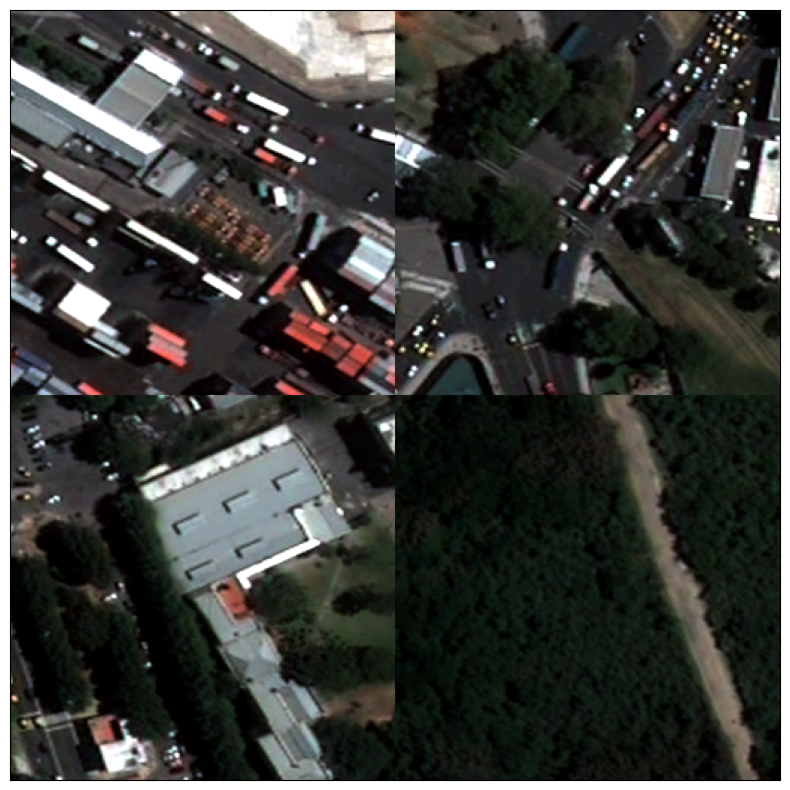

In [229]:
import earthpy.plot as ep

ep.plot_rgb(img,
            rgb=[0, 1, 2],
            stretch=True,)
plt.show()

In [89]:
def find_nearest_raster(x_array, y_array, x_value, y_value, max_bias=0):
    """If bias is added, then the point is moved randomly within a circle of radius max_bias (in pixels)."""

    # Calculate the bias for each axis
    angle_bias = np.random.uniform(0, 360)
    x_bias = np.cos(angle_bias) * max_bias
    y_bias = np.sin(angle_bias) * max_bias

    # Get the nearest index for each axis and add the bias
    x_idx = find_nearest_idx(x_array, x_value) + x_bias
    y_idx = find_nearest_idx(y_array, y_value) + y_bias
    return x_idx, y_idx


In [99]:
ds

<xarray.Dataset>
Dimensions:      (band: 4, x: 30720, y: 30720)
Coordinates:
  * band         (band) int32 1 2 3 4
  * x            (x) float64 -58.44 -58.44 -58.44 ... -58.29 -58.29 -58.29
  * y            (y) float64 -34.53 -34.53 -34.53 ... -34.67 -34.67 -34.67
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [98]:
point

(-58.37511890405979, -34.586526616146806)

In [97]:
find_nearest_raster(ds.x, ds.y, x, y, max_bias=max_bias)

(12965.0, 12024.0)

In [104]:
ds

<xarray.Dataset>
Dimensions:      (band: 4, x: 30720, y: 30720)
Coordinates:
  * band         (band) int32 1 2 3 4
  * x            (x) float64 -58.44 -58.44 -58.44 ... -58.29 -58.29 -58.29
  * y            (y) float64 -34.53 -34.53 -34.53 ... -34.67 -34.67 -34.67
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [105]:
idx_x_min, idx_x_max

(12837.0, 13093.0)

In [165]:
import utils

link = "020010101"
size= 512 
ds = datasets["pansharpened_6741387101_R1C1"]
tiles = 1

images = []
tile_size = size // tiles
for tile in range(0, tiles**2):
    if tile==0:
        max_bias = 0
    else:
        max_bias = tile_size * 4
        
    # Obtengo un punto aleatorio del radio censal con un buffer de tamaño size
    x, y = random_point_from_geometry(icpag.loc[icpag["link"] == link], tile_size)
    point = (x[0], y[0])

    # Identifico el raster más cercano a este punto -- va a ser el centro de la imagen
    idx_x, idx_y = find_nearest_raster(ds.x, ds.y, x, y, max_bias=max_bias)

    # # Genero el cuadrado que quiero capturar en la imagen
    idx_x_min = round(idx_x - tile_size / 2)
    idx_x_max = round(idx_x + tile_size / 2)
    idx_y_min = round(idx_y - tile_size / 2)
    idx_y_max = round(idx_y + tile_size / 2)

    # Filtro el dataset para quedarme con esa imagen
    my_ds = ds.isel(x=slice(idx_x_min, idx_x_max), y=slice(idx_y_min, idx_y_max))

    image = my_ds.band_data.to_numpy().astype(np.uint16)
    images += [image]

stacks = []
for i in range(0, tiles):
    stack = np.hstack(images[i::tiles])
    stacks += [stack]
    
compose = np.dstack(stacks)


In [163]:
stacks = []
for i in range(0, tiles):
    stack = np.hstack(images[i::tiles])
    stacks += [stack]
    
compose = np.dstack(stacks)


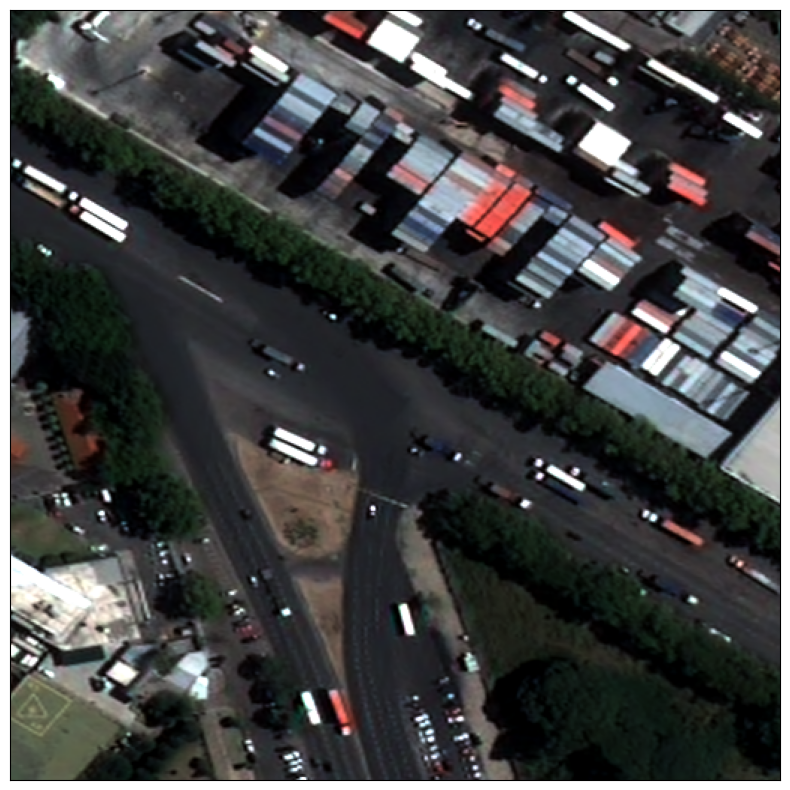

In [166]:
import earthpy.plot as ep

ep.plot_rgb(compose,
            rgb=[0, 1, 2],
            stretch=True)
plt.show()

In [47]:
images[1]

IndexError: list index out of range

In [3]:
import pandas as pd
pd.read_csv(r"D:\Maestría\Tesis\Repo\data\data_out\size512_sample5\metadata.csv")

,Unnamed: 0,point,sample,link,image,var
0,020010101_0,"(-58.371925678413625, -34.59168687592764)",0,20010101,D:/Maestría/Tesis/Repo/data/data_out\size512_s...,818.70233
1,020010101_1,"(-58.371925678413625, -34.59168687592764)",1,20010101,D:/Maestría/Tesis/Repo/data/data_out\size512_s...,818.70233
2,020010101_2,"(-58.371925678413625, -34.59168687592764)",2,20010101,D:/Maestría/Tesis/Repo/data/data_out\size512_s...,818.70233
3,020010101_3,"(-58.371925678413625, -34.59168687592764)",3,20010101,D:/Maestría/Tesis/Repo/data/data_out\size512_s...,818.70233
4,020010101_4,"(-58.371925678413625, -34.59168687592764)",4,20010101,D:/Maestría/Tesis/Repo/data/data_out\size512_s...,818.70233
...,...,...,...,...,...,...
58325,068613310_0,"(-58.371925678413625, -34.59168687592764)",0,68613310,D:/Maestría/Tesis/Repo/data/data_out\size512_s...,922.37670
58326,068613310_1,"(-58.371925678413625, -34.59168687592764)",1,68613310,D:/Maestría/Tesis/Repo/data/data_out\size512_s...,922.37670
58327,068613310_2,"(-58.371925678413625, -34.59168687592764)",2,68613310,D:/Maestría/Tesis/Repo/data/data_out\size512_s...,922.37670
58328,068613310_3,"(-58.371925678413625, -34.59168687592764)",3,68613310,D:/Maestría/Tesis/Repo/data/data_out\size512_s...,922.37670


Cargando datasets...


d:\Maestría\Tesis\Repo\scripts\build_dataset.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  icpag.loc[icpag.centroid.within(bbox), "dataset"] = name
d:\Maestría\Tesis\Repo\scripts\build_dataset.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  icpag.loc[icpag.centroid.within(bbox), "dataset"] = name


Links without images: 3448 out of 15114
Generando imágenes...


  9%|▉         | 1105/11666 [47:31<7:34:14,  2.58s/it]


KeyboardInterrupt: 

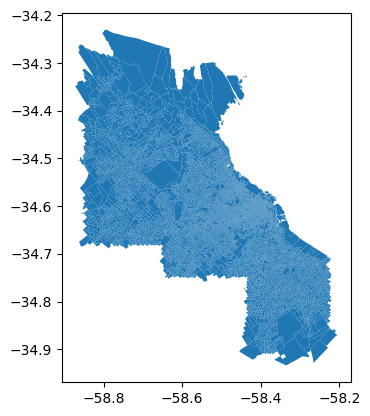

In [2]:
from build_dataset import build_dataset

build_dataset(image_size=512, sample_size=5, tiles=1, variable="pred_inc_mean")

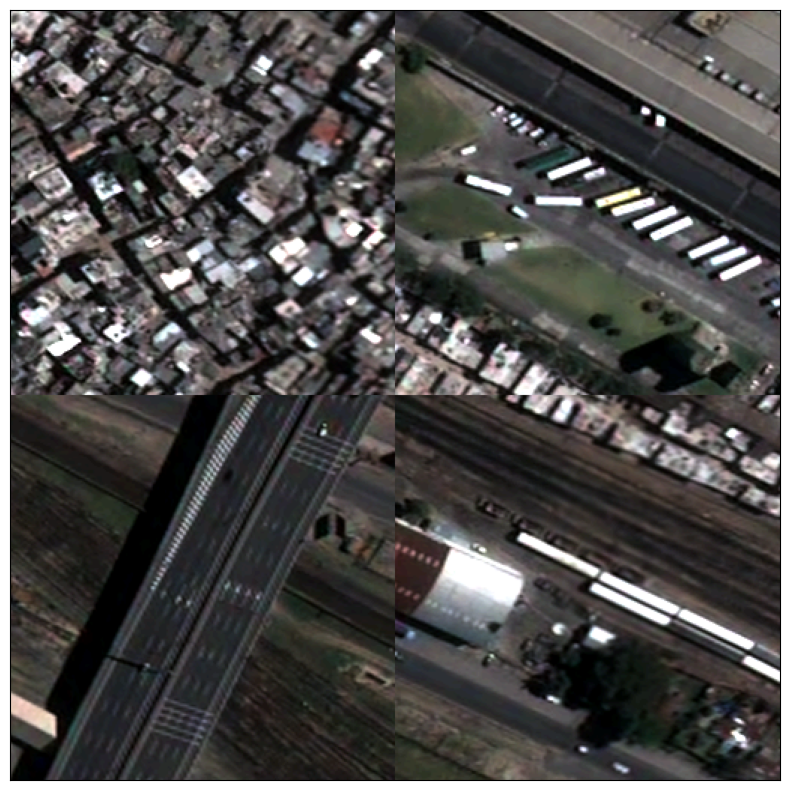

NameError: name 'plt' is not defined

In [11]:
import numpy as np
img = np.load(r"D:\Maestría\Tesis\Repo\data\data_out\size512_sample5\020010211_4.npy")

import earthpy.plot as ep

ep.plot_rgb(img,
            rgb=[0, 1, 2],
            stretch=True)
plt.show()

In [2]:
from run_model import run

image_size = 512
sample_size = 10

variable = "pred_inc_mean"
kind = "reg"
model = "mobnet_v3"

run(
    model_name=model,
    pred_variable=variable,
    kind=kind,
    small_sample=True,
    weights="imagenet",
)


ModuleNotFoundError: No module named 'tensorflow'

In [3]:
metadata = {}
metadata["a"] = {
    "point": 1,
    "sample": 2,
    "link": 3,
    "var": 4,
}

metadata["b"] = {
    "point": 1,
    "sample": 2,
    "link": 3,
    "var": 4,
}


In [8]:
import pandas as pd
pd.DataFrame().from_dict(metadata, orient='index')

,point,sample,link,var
a,1,2,3,4
b,1,2,3,4


In [ ]:
ep.plot_rgb(img,
            rgb=[0, 1, 2],
            )
plt.show()

In [ ]:
# Add satellite tiles
polygon.explore(tiles="https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="ESRI")